# [Time Series Analysis Learning Note] Bitcoin Price Prediction (ARIMA)
[Data src](https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data/data)
[Code ref](https://www.kaggle.com/code/myonin/bitcoin-price-prediction-by-arima/notebook)
[Other ref](https://www.statsmodels.org/stable/tsa.html#module-statsmodels.tsa)

In [4]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
sns.set_context("poster")
#plt.style.use('seaborn-poster')

In [12]:
df = pd.read_csv("datasets/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")
df

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
4857372,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
4857373,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
4857374,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
4857375,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202


In [39]:
df = df.rename(columns={'Volume_(Currency)': 'Volume_Currency', 'Volume_(BTC)': 'Volume_BTC'})
df   

,Timestamp,Open,High,Low,Close,Volume_BTC,Volume_Currency,Weighted_Price
Timestamp,,,,,,,,
2011-12-31,2011-12-31 15:55:30,4.465000,4.482500,4.465000,4.482500,23.829470,106.330084,4.471603
2012-01-01,2012-01-01 11:59:30,4.806667,4.806667,4.806667,4.806667,7.200667,35.259720,4.806667
2012-01-02,2012-01-02 11:59:30,5.000000,5.000000,5.000000,5.000000,19.048000,95.240000,5.000000
2012-01-03,2012-01-03 11:59:30,5.252500,5.252500,5.252500,5.252500,11.004660,58.100651,5.252500
2012-01-04,2012-01-04 11:59:30,5.200000,5.223333,5.200000,5.223333,11.914807,63.119577,5.208159
...,...,...,...,...,...,...,...,...
2021-03-27,2021-03-27 11:59:30,55193.240643,55219.665031,55168.757372,55195.415367,1.823877,100884.732367,55193.357260
2021-03-28,2021-03-28 11:59:30,55833.608471,55857.735342,55810.425126,55835.012863,1.447939,80632.115263,55832.958824
2021-03-29,2021-03-29 11:59:30,56914.886595,56946.213593,56885.242967,56915.629993,3.732887,213754.555988,56913.993819


In [40]:
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')
df.Timestamp

Timestamp
2011-12-31   2011-12-31 15:55:30
2012-01-01   2012-01-01 11:59:30
2012-01-02   2012-01-02 11:59:30
2012-01-03   2012-01-03 11:59:30
2012-01-04   2012-01-04 11:59:30
                     ...        
2021-03-27   2021-03-27 11:59:30
2021-03-28   2021-03-28 11:59:30
2021-03-29   2021-03-29 11:59:30
2021-03-30   2021-03-30 11:59:30
2021-03-31   2021-03-31 00:00:00
Name: Timestamp, Length: 3379, dtype: datetime64[ns]

In [41]:
# Resampling to daily frequency
df.index = df.Timestamp
df = df.resample('D').mean()
df

,Timestamp,Open,High,Low,Close,Volume_BTC,Volume_Currency,Weighted_Price
Timestamp,,,,,,,,
2011-12-31,2011-12-31 15:55:30,4.465000,4.482500,4.465000,4.482500,23.829470,106.330084,4.471603
2012-01-01,2012-01-01 11:59:30,4.806667,4.806667,4.806667,4.806667,7.200667,35.259720,4.806667
2012-01-02,2012-01-02 11:59:30,5.000000,5.000000,5.000000,5.000000,19.048000,95.240000,5.000000
2012-01-03,2012-01-03 11:59:30,5.252500,5.252500,5.252500,5.252500,11.004660,58.100651,5.252500
2012-01-04,2012-01-04 11:59:30,5.200000,5.223333,5.200000,5.223333,11.914807,63.119577,5.208159
...,...,...,...,...,...,...,...,...
2021-03-27,2021-03-27 11:59:30,55193.240643,55219.665031,55168.757372,55195.415367,1.823877,100884.732367,55193.357260
2021-03-28,2021-03-28 11:59:30,55833.608471,55857.735342,55810.425126,55835.012863,1.447939,80632.115263,55832.958824
2021-03-29,2021-03-29 11:59:30,56914.886595,56946.213593,56885.242967,56915.629993,3.732887,213754.555988,56913.993819


### `Resample` function:
```
DataFrame.resample(rule, axis=0, closed=None, label=None, convention='start', kind=None, loffset=None, base=0, on=None, level=None)
```
:para:`rule`: The offset string or object representing target conversion.

------
'min' or 'T': Minute
'H': Hour
'D': Calendar day
'B': Business day
'W': Weekly (with various options like 'W-MON' for weekly on Monday)
'M': Month end
'BM': Business month end
'MS': Month start
'BMS': Business month start
'Q': Quarter end
'BQ': Business quarter end
'QS': Quarter start
'BQS': Business quarter start
'A', 'Y': Year end
'BA', 'BY': Business year end
'AS', 'YS': Year start
'BAS', 'BYS': Business year start
'SM': Semi-Month End Frequency (15th and end of month)
'SMS': Semi-Month Start Frequency (1st and 15th)
In addition to these, there are also more complex rules like:
'2H': Every two hours
'1D3H': Every 1 day and 3 hours

------

In [46]:
# Resampling to monthly frequency
df_month = df.resample('M').mean()
print(type(df_month), df_month)

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

# Resampling to quarterly frequency
df_quar = df.resample('Q-DEC').mean()

<class 'pandas.core.frame.DataFrame'>                                Timestamp          Open          High  \
Timestamp                                                              
2011-12-31 2011-12-31 15:55:30.000000000      4.465000      4.482500   
2012-01-31 2012-01-16 11:59:30.000000000      6.208043      6.210657   
2012-02-29 2012-02-15 11:59:30.000000000      5.253117      5.255079   
2012-03-31 2012-03-16 11:59:30.000000000      4.963496      4.964408   
2012-04-30 2012-04-15 23:59:30.000000000      4.976732      4.978059   
...                                  ...           ...           ...   
2020-11-30 2020-11-15 23:59:30.000000000  16530.188884  16540.060546   
2020-12-31 2020-12-16 11:59:30.000000000  21810.891586  21825.256165   
2021-01-31 2021-01-16 11:59:30.000000000  34553.473084  34593.508742   
2021-02-28 2021-02-14 23:59:30.000000256  46076.500756  46116.985465   
2021-03-31 2021-03-16 11:36:17.419354880  54639.891296  54674.763269   

                     Low 

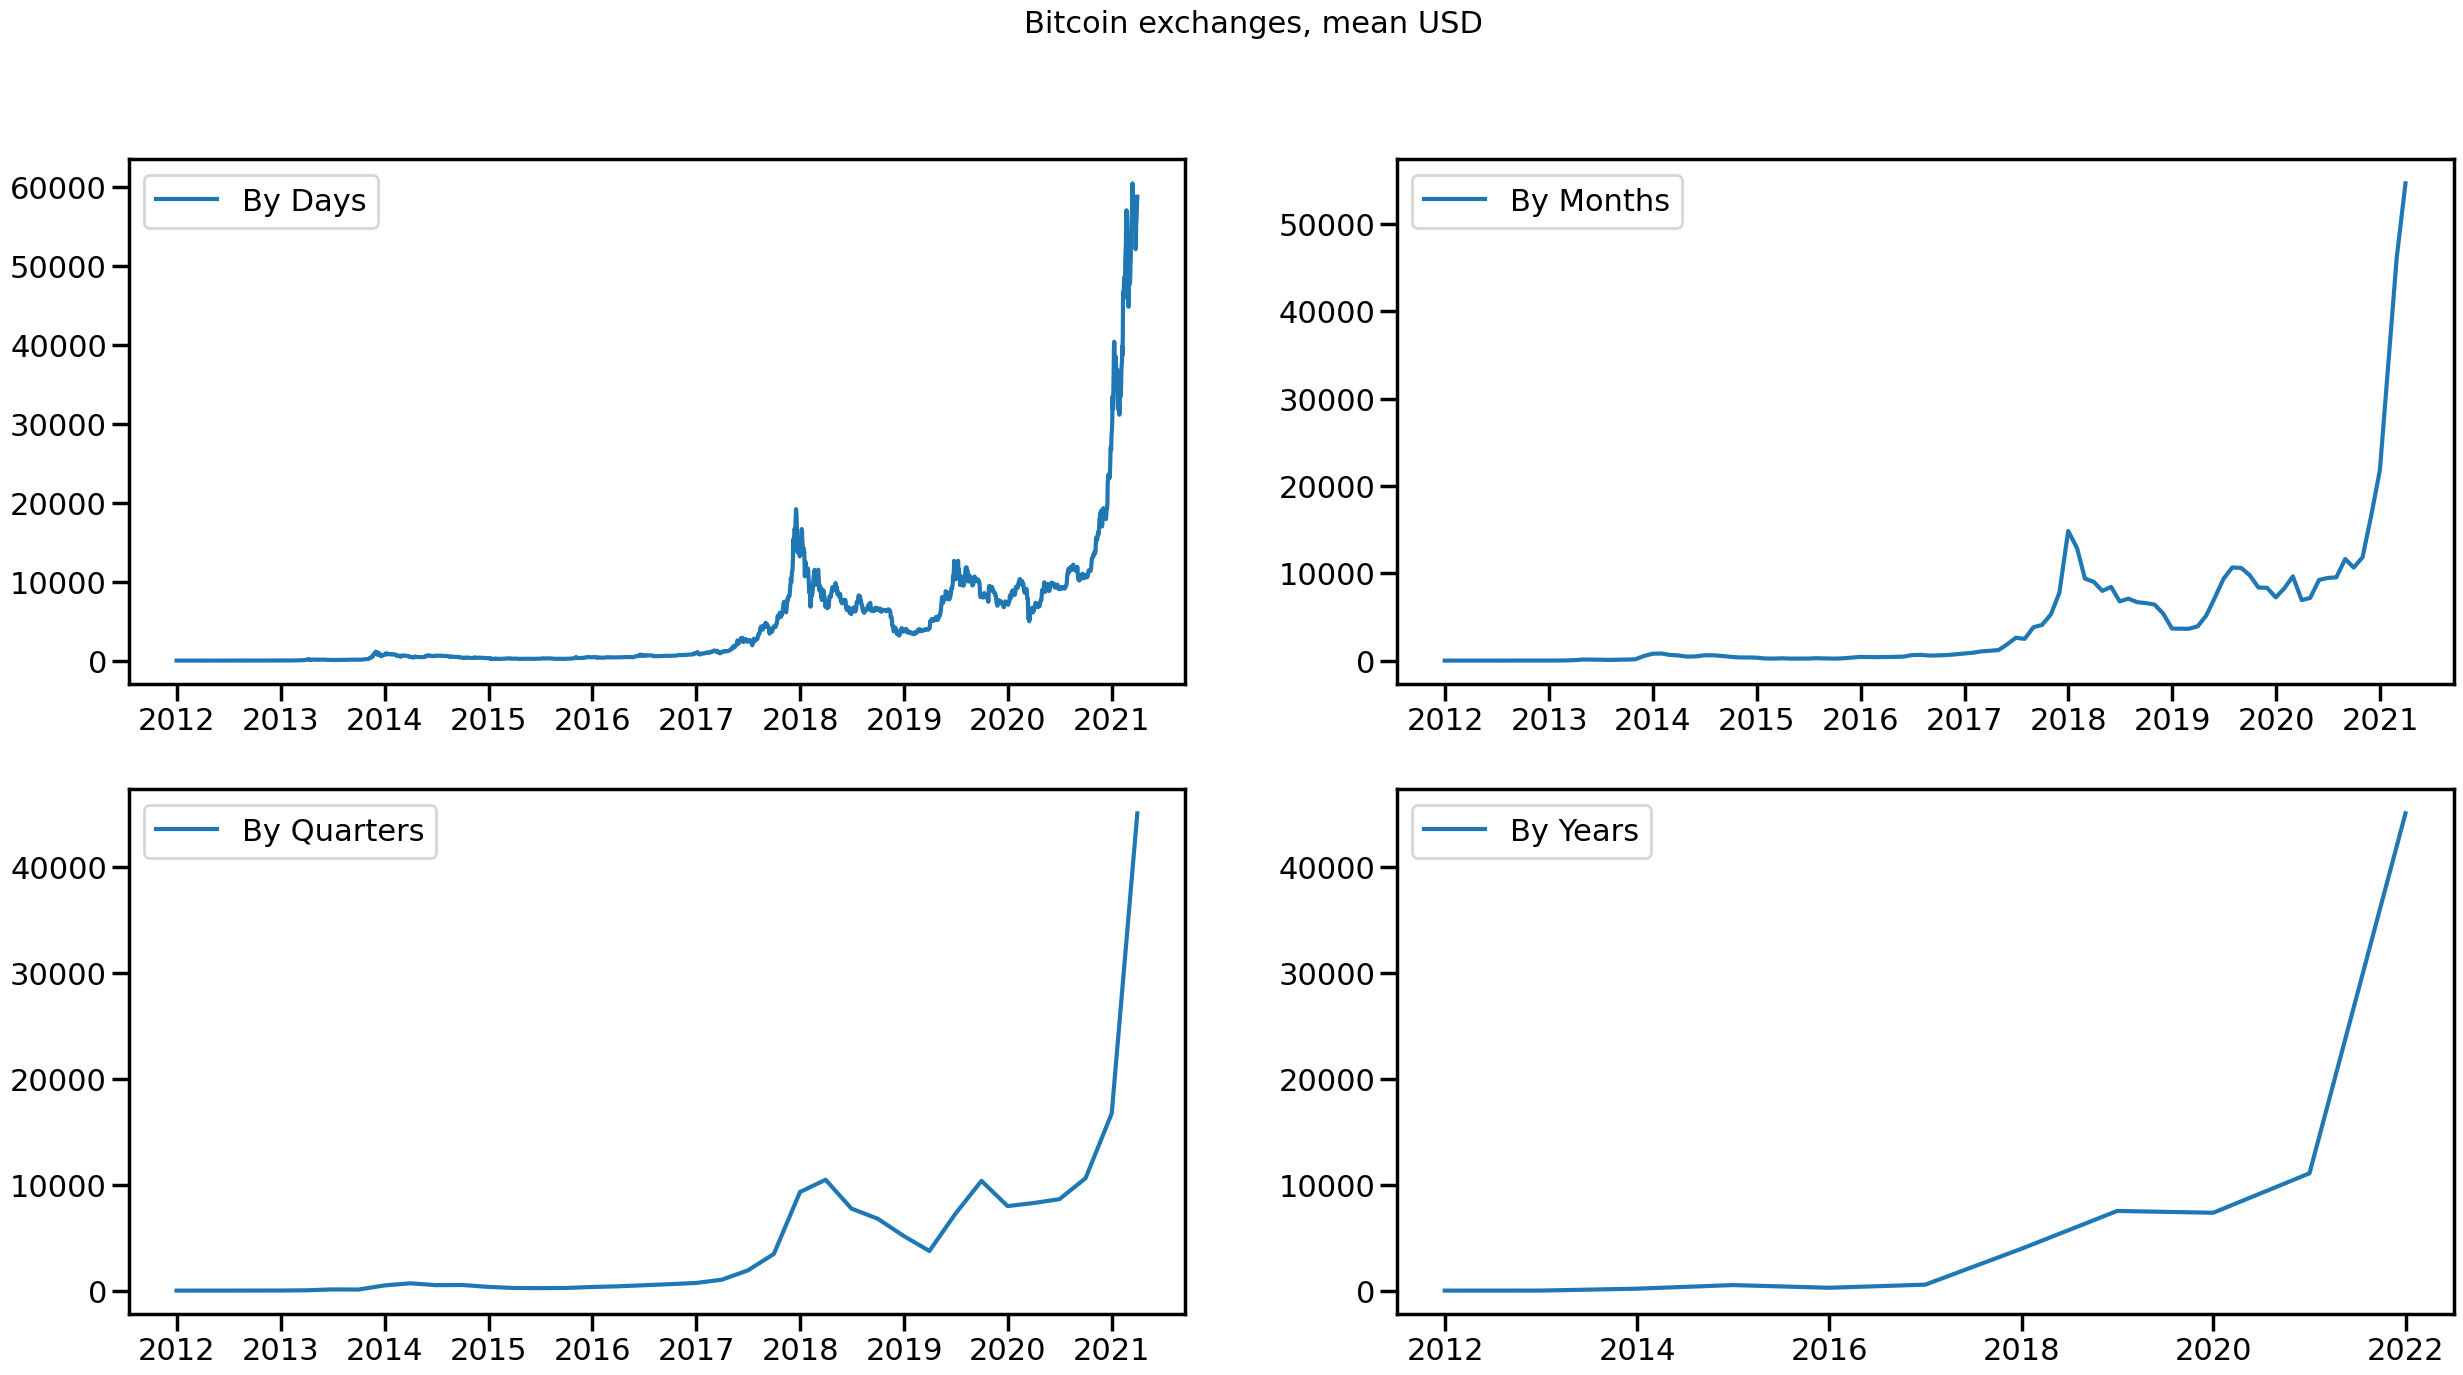

In [47]:
# PLOTS
fig = plt.figure(figsize=[30, 15])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df.Weighted_Price, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month.Weighted_Price, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_quar.Weighted_Price, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.Weighted_Price, '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

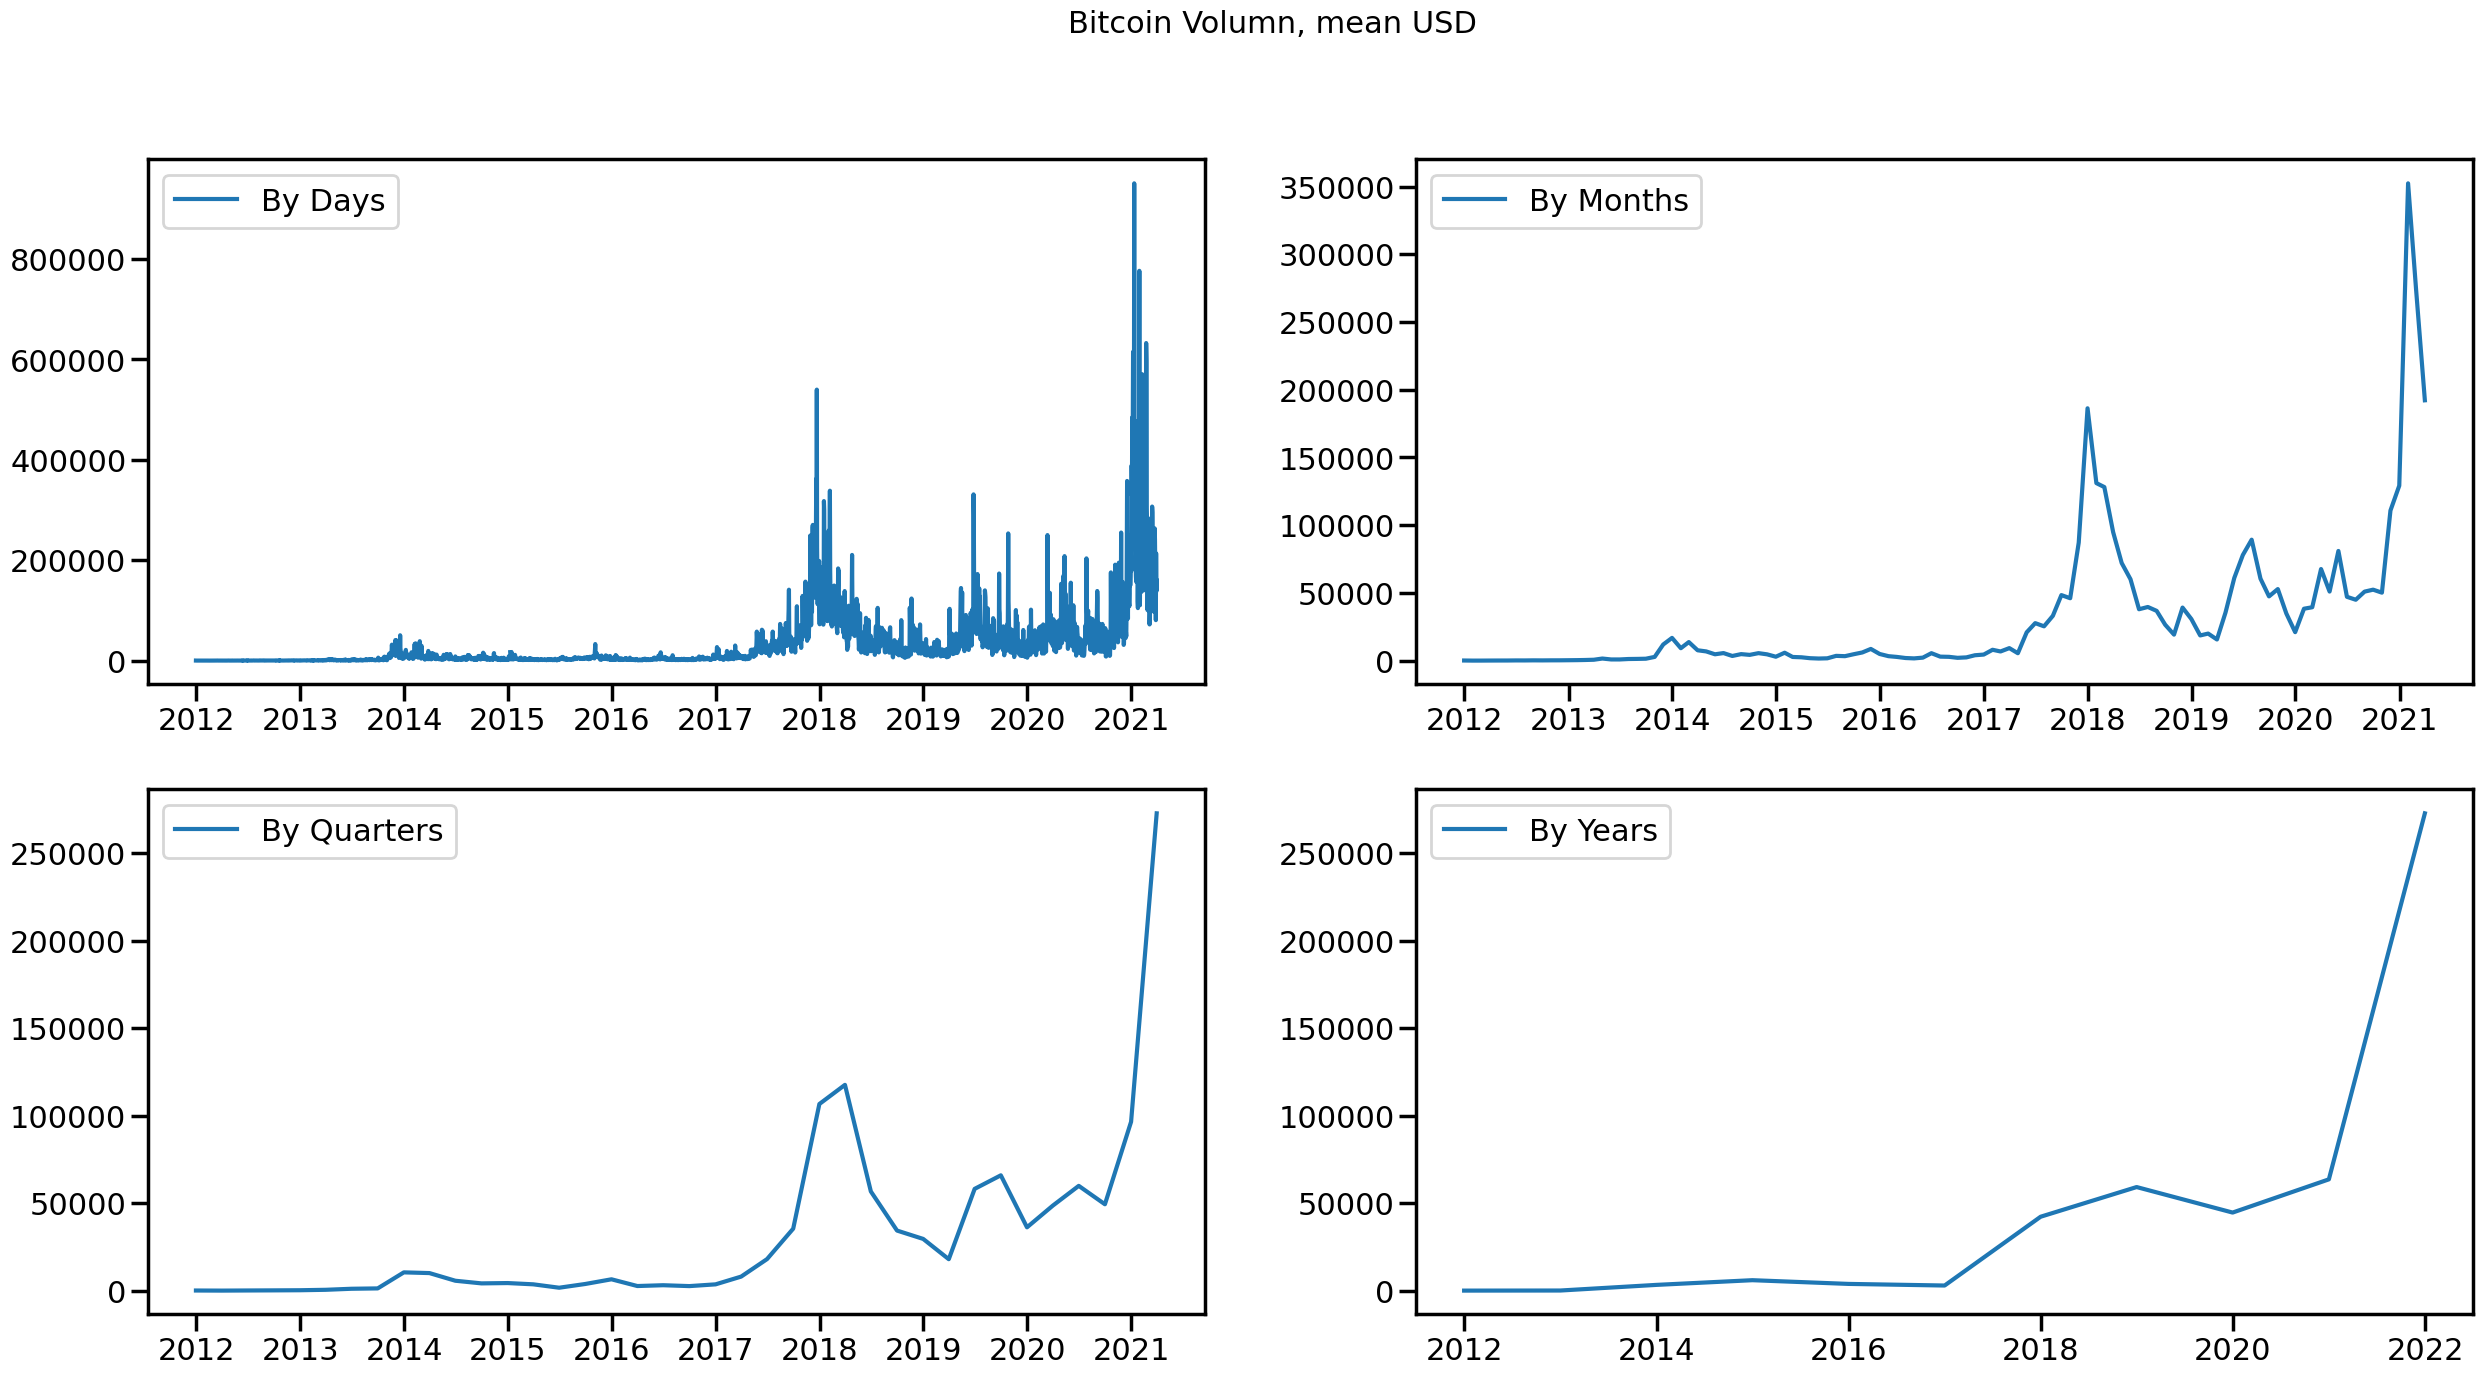

In [48]:
# PLOTS
fig = plt.figure(figsize=[30, 15])
plt.suptitle('Bitcoin Volumn, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df.Volume_Currency, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month.Volume_Currency, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_quar.Volume_Currency, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.Volume_Currency, '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

Dickey–Fuller test: p=0.998863


<Figure size 1500x700 with 0 Axes>

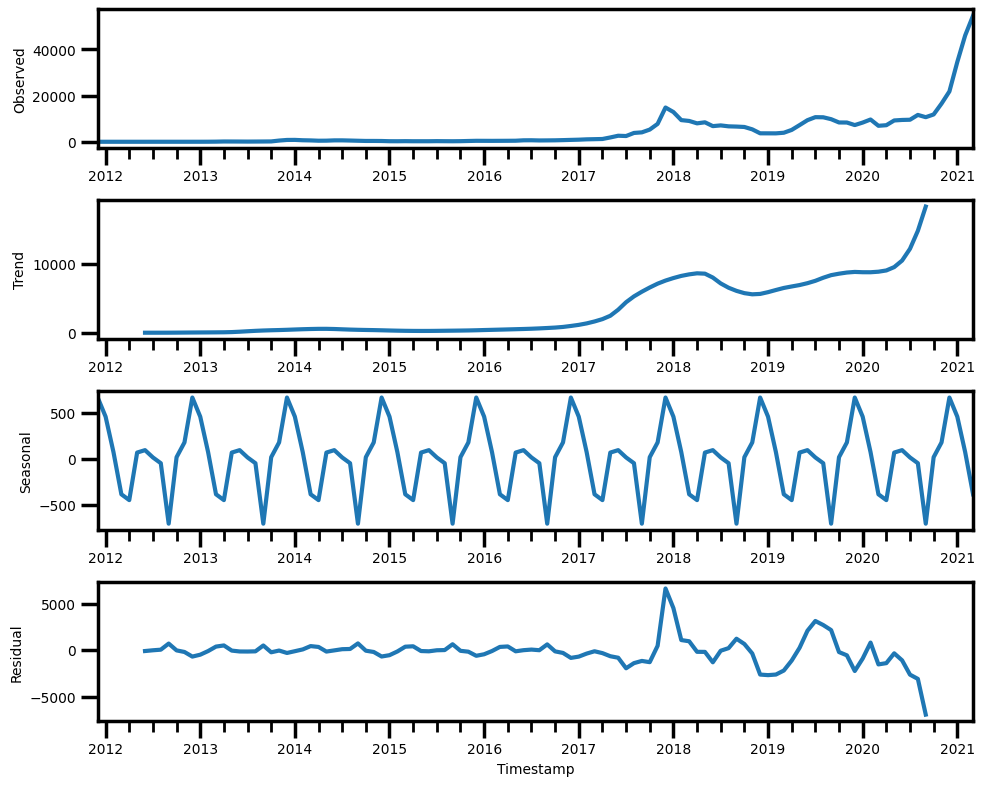

In [82]:
plt.figure(figsize=(15,7))
#sm.tsa.seasonal_decompose(df_month.Weighted_Price).plot() # 比例詭異 -> 重畫
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])

# Create a figure with subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))

# Decompose the time series
decomposition = sm.tsa.seasonal_decompose(df_month.Weighted_Price)

# Plotting the observed component
decomposition.observed.plot(ax=ax1)
ax1.set_ylabel('Observed', fontsize=10)
ax1.set_xlabel('')
ax1.tick_params(axis='both', which='major', labelsize=10)

# Plotting the trend component
decomposition.trend.plot(ax=ax2)
ax2.set_ylabel('Trend', fontsize=10)
ax2.set_xlabel('')
ax2.tick_params(axis='both', which='major', labelsize=10)

# Plotting the seasonal component
decomposition.seasonal.plot(ax=ax3) #, title='Seasonal'
ax3.set_ylabel('Seasonal', fontsize=10)
ax3.set_xlabel('')
ax3.tick_params(axis='both', which='major', labelsize=10)

# Plotting the residual component
decomposition.resid.plot(ax=ax4) #, title='Residual')
ax4.set_ylabel('Residual', fontsize=10)
ax4.set_xlabel('Timestamp',fontsize = 10)
ax4.tick_params(axis='both', which='major', labelsize=10)

# Adjusting the layout
plt.tight_layout(pad = 0.5)
plt.show()

## Box-Cox Trasformation 
a statistical tool that transforms non-normal data into a normal distribution
Box-Cox變換之後，可以一定程度上減小不可觀測的誤差和預測變量的相關性。Box-Cox變換的主要特點是引入一個參數，通過數據本身估計該參數進而確定應採取的數據變換形式。
### Dickey-Fuller test 
a statistical method for determining whether a time series is stationary 

In [84]:
df_month['Weighted_Price_box'], lmbda = stats.boxcox(df_month.Weighted_Price)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])

Dickey–Fuller test: p=0.998863


In [86]:
df_quar['Weighted_Price_box'], lmbda = stats.boxcox(df_quar.Weighted_Price)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_quar.Weighted_Price)[1])

Dickey–Fuller test: p=0.999086


In [85]:
df_year['Weighted_Price_box'], lmbda = stats.boxcox(df_year.Weighted_Pricea
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_year.Weighted_Price)[1])

Dickey–Fuller test: p=1.000000


In [97]:
# Seasonal differentiation
df_month['prices_box_diff'] = df_month.Weighted_Price_box - df_month.Weighted_Price_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.444282


! The series are not stationary. 

Dickey–Fuller test: p=0.000024


<Figure size 1500x700 with 0 Axes>

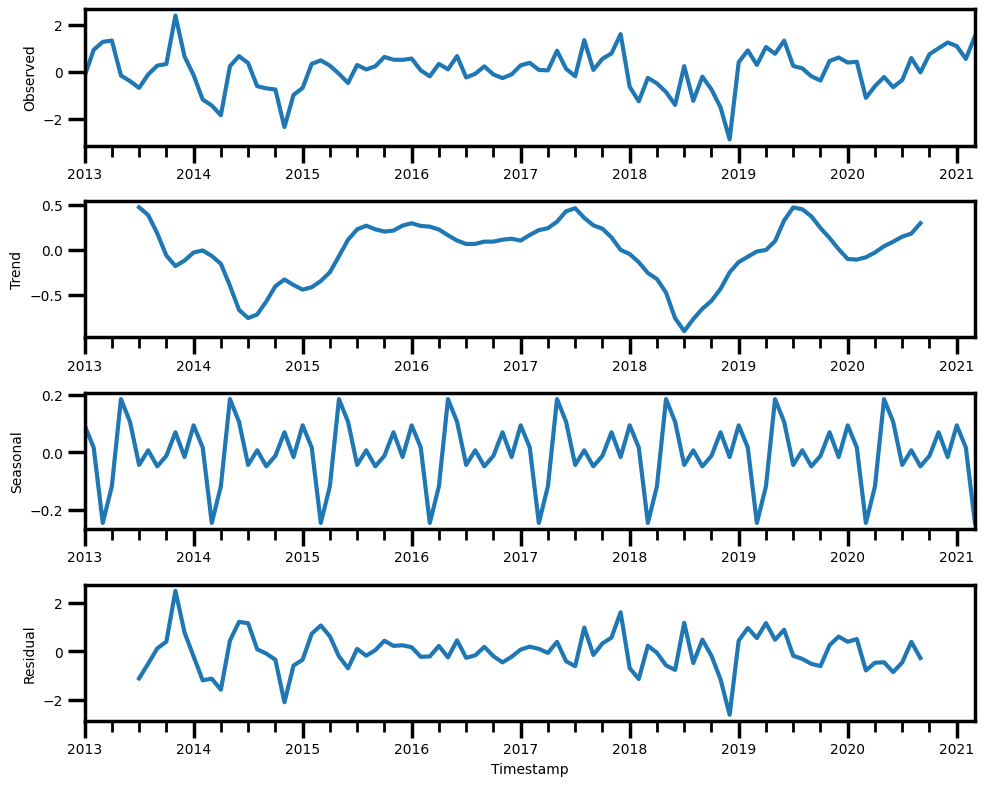

In [100]:
# Regular differentiation
df_month['prices_box_diff2'] = df_month.prices_box_diff - df_month.prices_box_diff.shift(1)
plt.figure(figsize=(15,7))

# STL-decomposition
# sm.tsa.seasonal_decompose(df_month.prices_box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff2[13:])[1])

# Create a figure with subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))

# Decompose the time series
decomposition = sm.tsa.seasonal_decompose(df_month.prices_box_diff2[13:])

# Plotting the observed component
decomposition.observed.plot(ax=ax1)
ax1.set_ylabel('Observed', fontsize=10)
ax1.set_xlabel('')
ax1.tick_params(axis='both', which='major', labelsize=10)

# Plotting the trend component
decomposition.trend.plot(ax=ax2)
ax2.set_ylabel('Trend', fontsize=10)
ax2.set_xlabel('')
ax2.tick_params(axis='both', which='major', labelsize=10)

# Plotting the seasonal component
decomposition.seasonal.plot(ax=ax3) #, title='Seasonal'
ax3.set_ylabel('Seasonal', fontsize=10)
ax3.set_xlabel('')
ax3.tick_params(axis='both', which='major', labelsize=10)

# Plotting the residual component
decomposition.resid.plot(ax=ax4) #, title='Residual')
ax4.set_ylabel('Residual', fontsize=10)
ax4.set_xlabel('Timestamp',fontsize = 10)
ax4.tick_params(axis='both', which='major', labelsize=10)

# Adjusting the layout
plt.tight_layout(pad = 0.5)
plt.show()

## Model Selection
*Ref* [TSA:: ACF, PACF, AIC..](https://medium.com/@cindy050244_52136/%E6%99%82%E9%96%93%E5%BA%8F%E5%88%97%E6%8E%A2%E7%B4%A2-%E4%B8%89-%E6%A8%A1%E5%9E%8B%E5%AE%9A%E9%9A%8E%E8%88%87%E7%AF%A9%E9%81%B8-2ebe90b121f9)

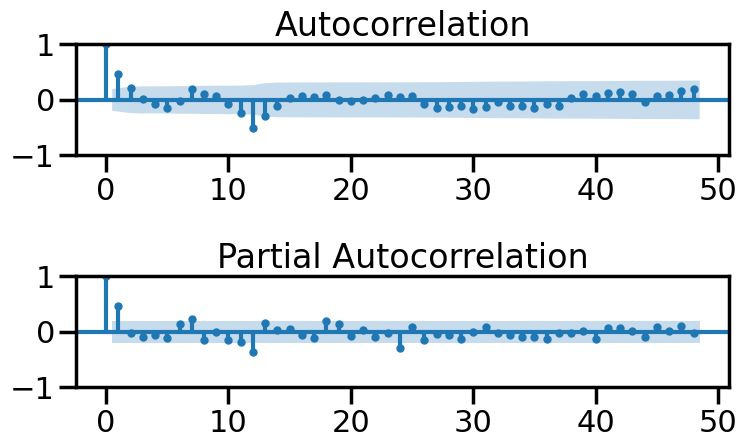

In [103]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(8,5))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

In [104]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_month.Weighted_Price_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [105]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
19  (1, 0, 0, 1)  173.616084
21  (1, 0, 1, 1)  174.766384
25  (1, 1, 0, 1)  175.547104
37  (2, 0, 0, 1)  175.553869
7   (0, 1, 0, 1)  175.589168
                                      SARIMAX Results                                       
Dep. Variable:                   Weighted_Price_box   No. Observations:                  112
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 -83.808
Date:                              Fri, 26 Jan 2024   AIC                            173.616
Time:                                      13:23:08   BIC                            181.401
Sample:                                  12-31-2011   HQIC                           176.766
                                       - 03-31-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---

## Residuals Analysis

Dickey–Fuller test:: p=0.000000


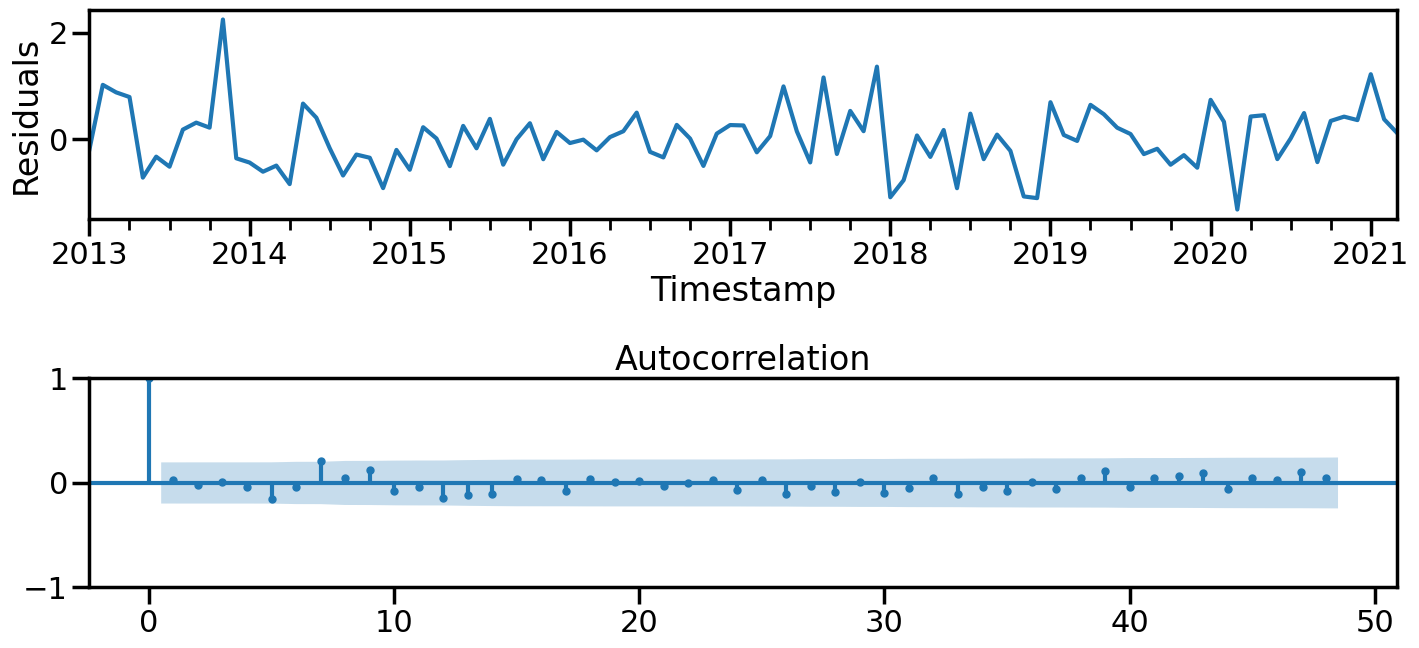

In [106]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

## Prediction

In [107]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [128]:
# check newest data
df_month[['Weighted_Price']]

,Weighted_Price
Timestamp,
2011-12-31,4.471603
2012-01-31,6.208550
2012-02-29,5.252527
2012-03-31,4.962021
2012-04-30,4.976547
...,...
2020-11-30,16530.401656
2020-12-31,21810.922846
2021-01-31,34551.684656


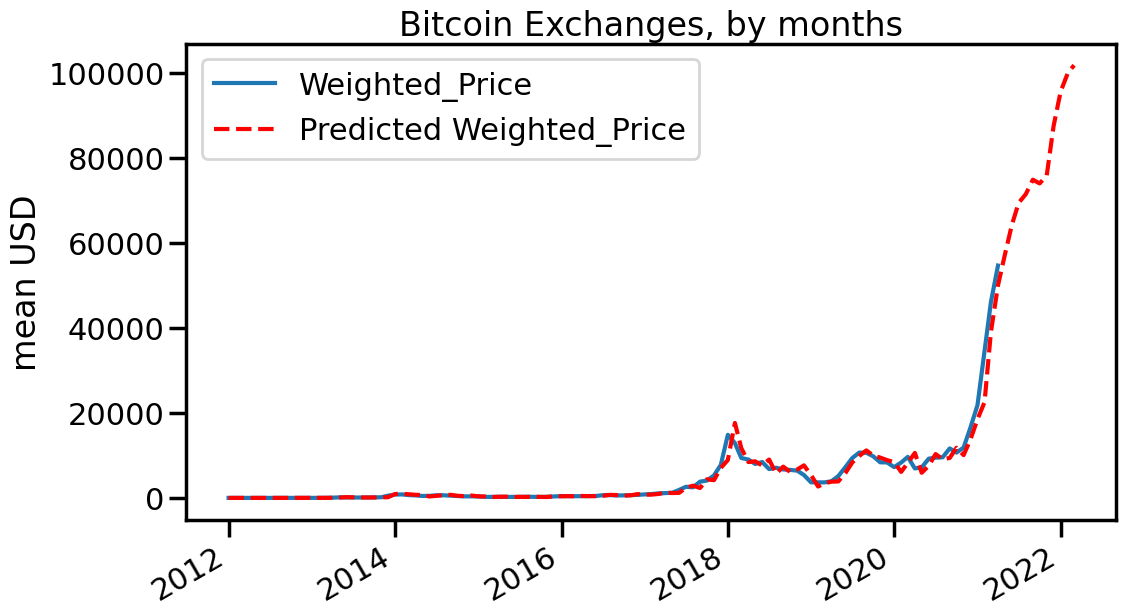

In [131]:
# Prediction
df_month2 = df_month[['Weighted_Price']]
date_list = [datetime(2021, 4, 30), datetime(2021, 5, 31), datetime(2021, 6, 30), 
             datetime(2021, 7, 31), datetime(2021, 8, 31), datetime(2021, 9, 30), 
             datetime(2021, 10, 31), datetime(2021, 11, 30), datetime(2021, 12, 31),
             datetime(2022, 1, 31), datetime(2022, 2, 28), datetime(2021, 3, 31),
            ]
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = invboxcox(best_model.predict(start=0, end=151), lmbda)
plt.figure(figsize=(12,7))
df_month2.Weighted_Price.plot()
df_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title('Bitcoin Exchanges, by months')
plt.ylabel('mean USD')
plt.show()


In [132]:
future

,Timestamp,Open,High,Low,Close,Volume_BTC,Volume_Currency,Weighted_Price,Weighted_Price_box,prices_box_diff,prices_box_diff2
2021-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
